     new_pred0
0            3
1            3
2            3
3            3
4            3
..         ...
349          3
350          3
351          3
352          3
353          4

[354 rows x 1 columns]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000,

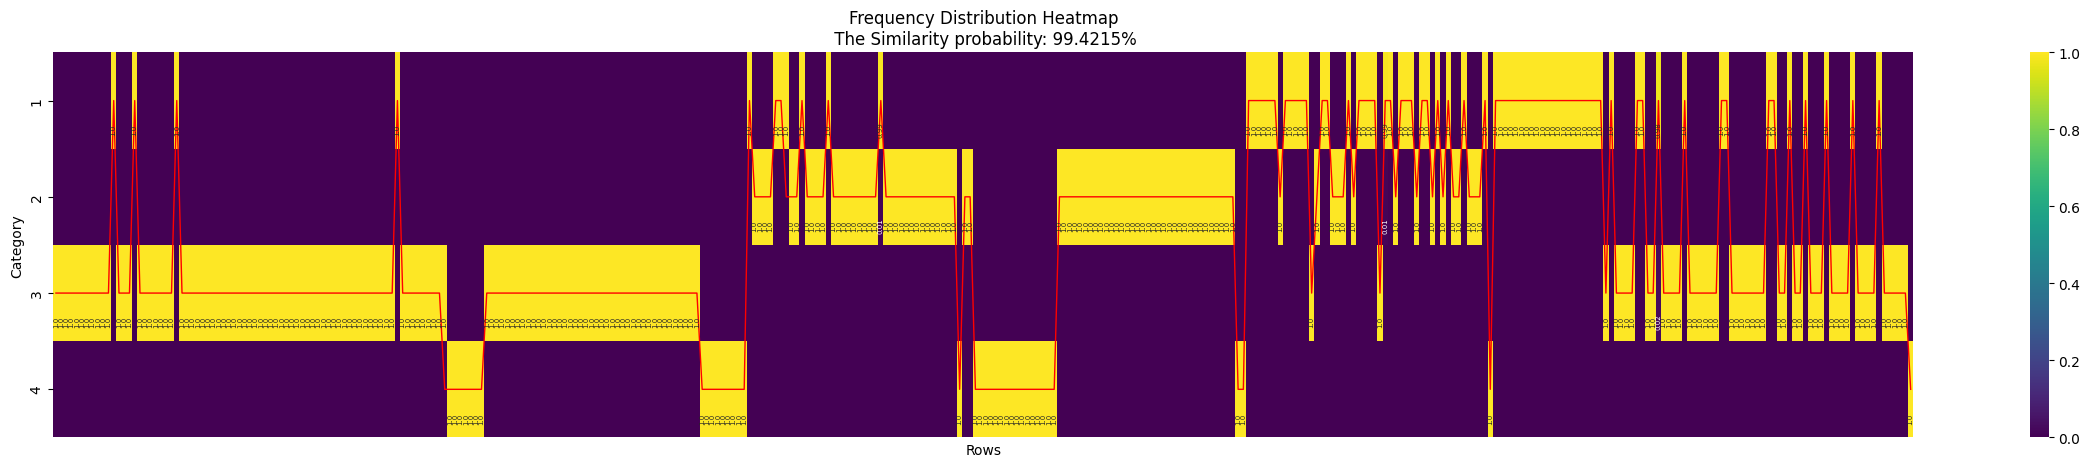

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import warnings 
warnings.filterwarnings("ignore")

# 复现结果
df = pd.read_csv("./test-out/s9_cluster.csv")

#原始结果
df_i = pd.read_csv("./test-out/s9_cluster.csv")
out0 = df["Out0"]=df_i["cluster"]
x= df.index
data = df.copy()

# 定义属性模板
attributes_template = ["Rooftop_area{}", 'Radiation0', 'Emission0']
original_attributes = ["Rooftop Area (km2)", "Annual Surface Solar Radiation (Kwh/m2)", "Grid Emission Factor (gCO2/Kwh)"]

# 初始化结果数据框
index_names = [f'Rooftop_area_{i}' for i in range(1, 5)] + [f'Radiation_{i}' for i in range(1, 5)] + [f'Emission_{i}' for i in range(1, 5)]
results_df = pd.DataFrame(index=index_names)


# 计算特定聚类的质心的函数
def calculate_centroids_with_attrs(data, clustering_col, attributes):
    centroids = {}
    for cluster_id in range(1, 5):
        cluster_data = data[data[clustering_col] == cluster_id]
        centroid = cluster_data[attributes].mean()
        centroids[cluster_id] = centroid
    return centroids

def calculate_row(data, cluster_col, attributes, row_name, df):
    centroids = calculate_centroids_with_attrs(data, cluster_col, attributes)
    
    # 提取质心值并构建一个数据框
    centroids_df = pd.DataFrame(centroids).T
    centroids_df.columns = ['Rooftop_area', 'Radiation', 'Emission']
    
    # 按照Rooftop_area进行排序
    centroids_df = centroids_df.sort_values(by='Rooftop_area')
    
    # 重新分配新的聚类标签
    sorted_clusters = centroids_df.index.tolist()
    cluster_mapping = {original_cluster: new_cluster for new_cluster, original_cluster in enumerate(sorted_clusters, start=1)}
    data[f'new_{cluster_col}'] = data[cluster_col].map(cluster_mapping)
    
    # 重新计算新的聚类质心
    new_centroids = calculate_centroids_with_attrs(data, f'new_{cluster_col}', attributes)
    new_centroids_df = pd.DataFrame(new_centroids).T
    new_centroids_df.columns = ['Rooftop_area', 'Radiation', 'Emission']
    
    # 将排序后的结果添加到结果数据框中
    df[row_name] = list(new_centroids_df['Rooftop_area']) + list(new_centroids_df['Radiation']) + list(new_centroids_df['Emission'])

    return data, df

# 计算每个复现聚类结果的质心
for i in range(0, 1001):
    cluster_col = f'pred{i}'
    attributes = [attr.format(i) if "{}" in attr else attr for attr in attributes_template]
    if i == 0:
        attributes = original_attributes
    data_repro, results_df = calculate_row(data, cluster_col, attributes, f'Out{i}', results_df)

data.to_csv('repro-out/filtered_data.csv')

# 筛选data_repro中包含新列的部分
filtered_data_repro = data[[f'new_pred{i}' for i in range(1, 1001)]]

# 计算每一行的cluster数及出现的频率
cluster_counts = filtered_data_repro.apply(pd.Series.value_counts, axis=1).fillna(0)
cluster_frequencies = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# new_pred_cols = [f'new_pred{i}' for i in range(1, 1001)]
# filtered_data_repro['clusters_array'] = filtered_data_repro[new_pred_cols].apply(lambda row: row.unique(), axis=1)


filtered_data_repro.to_csv('repro-out/filtered_data_repro.csv')
# print(filtered_data_repro)

filtered_data_initial = data[[f'new_pred0']]
print(filtered_data_initial)

import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('repro-out/filtered_data.csv')

relative_frequency=[]

# 创建频率分布图的函数
def plot_histogram(row_data, row_index):
    initial_value=filtered_data_initial.loc[row_index,:].values[0]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    # print(frequencies)
    
    categories = [1, 2, 3, 4]
    frequency_values = [frequencies.get(category, 0) for category in categories]
    print(frequency_values)
    # 确定initial_value所在的类别及其频率
    initial_category = int(initial_value)
    initial_frequency = frequencies.get(initial_category, 0)
    relative_frequency.append(initial_frequency / len(row_data)) 
    # print(initial_relative_frequency)

    # plt.figure(figsize=(10, 6))
    # plt.bar(categories, frequency_values, tick_label=categories,alpha=0.3,label="Reproduced values")
    # plt.title(f'Frequency Distribution of Row {row_index} \n The probability of reproducbility is {initial_frequency / len(row_data) *100}%')
    # plt.axvline(x=initial_category, color='red', linestyle='dashed', linewidth=2, label=f'Initial value: {initial_value}')
    # plt.legend()
    # plt.xlabel('Category')
    # plt.ylabel('Frequency')
    # plt.ylim(0, max(frequency_values) + 10)  # Adjust ylim for better visualization
    # plt.show()

# 为每一行绘制直方图 filtered_data_repro.shape[0]
# print(filtered_data_repro.loc[0,:])
data2 = pd.read_csv('repro-out/filtered_data_repro.csv')
# filtered_data_repro= data2.iloc[:,1:1001]
# print(filtered_data_repro)
for i in range(1,filtered_data_repro.shape[0]):
    plot_histogram(filtered_data_repro.loc[i,:], i)

# 计算initial_relative_frequency数组的期望（均值）
expected_value = np.mean(relative_frequency)
print("Expected Value of Initial Relative Frequencies:", expected_value)



import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 仅选择前20行的数据
# repro = filtered_data_repro.iloc[:200, :]
# initial = filtered_data_initial.iloc[:100, :]
repro = filtered_data_repro
initial = filtered_data_initial

# 创建一个矩阵来存储频率分布
frequency_matrix = np.zeros((repro.shape[0], 4))

# 填充频率矩阵
for i in range(repro.shape[0]):
    row_data = repro.loc[i, :]
    unique, counts = np.unique(row_data, return_counts=True)
    frequencies = dict(zip(unique, counts))
    for category in [1, 2, 3, 4]:
        frequency_matrix[i, category - 1] = frequencies.get(category, 0) / len(row_data)

# 创建一个矩阵来存储注释（只显示值大于0的标签）
annotations = np.where(frequency_matrix > 0, np.round(frequency_matrix, 2), '')

# 绘制热力图
plt.figure(figsize=(30, 5))
ax = sns.heatmap(frequency_matrix.T, annot=annotations.T, fmt="", xticklabels=False, yticklabels=[1, 2, 3, 4], cmap="viridis", cbar=True,
                 annot_kws={"size": 5, "ha": "center", "va": "center", "rotation": 90,"clip_on": True})
plt.title(f'Frequency Distribution Heatmap\n The Similarity probability: {round(expected_value*100,4)}%')
plt.ylabel('Category')
plt.xlabel('Rows')

# 调整标签的位置
for text in ax.texts:
    text.set_y(float(text.get_position()[1]) + 0.3)

# 添加表示filtered_data_initial的线
initial_values = initial['new_pred0'].values - 1  # 将值转换为索引
plt.plot(np.arange(0.5, repro.shape[0] + 0.5), initial_values + 0.5, color='red', linewidth=1, label='Initial Value')
plt.savefig("repro-out/heatmap.svg")
plt.show()



计算 ARI 统计量:
总误差(ARI): (0.9782, 0.9868)
随机误差(ARI): (0.9913, 1.0000)
随机覆盖总<总误差置信区间覆盖率: 0.3980；概率1.0
随机覆盖总>总误差置信区间覆盖率: 1.0000；概率1.0

计算 NMI 统计量:
总误差(NMI): (0.9635, 0.9761)
随机误差(NMI): (0.9873, 1.0000)
随机覆盖总<总误差置信区间覆盖率: 0.3476；概率1.0
随机覆盖总>总误差置信区间覆盖率: 1.0000；概率1.0

计算 Kappa 统计量:
总误差(Kappa): (0.9877, 0.9918)
随机误差(Kappa): (0.9959, 1.0000)
随机覆盖总<总误差置信区间覆盖率: 0.3338；概率0.9997
随机覆盖总>总误差置信区间覆盖率: 1.0000；概率0.9997


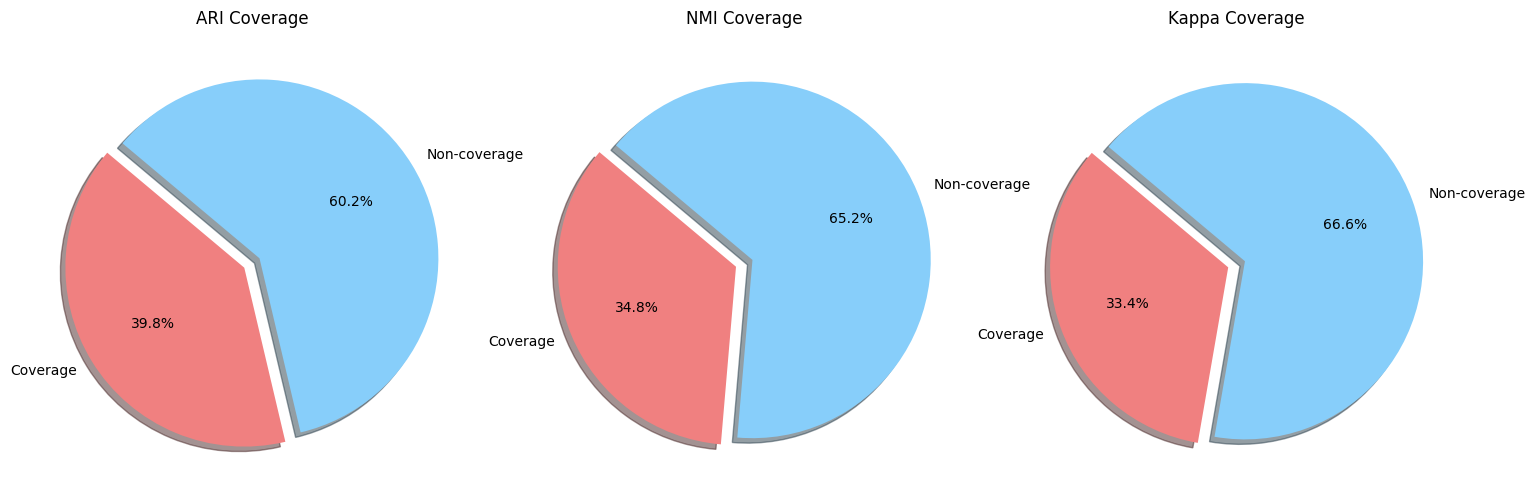

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, cohen_kappa_score
from itertools import combinations
import scipy.stats as stats

# 设定随机种子以确保结果一致


# 计算置信区间
def calculate_confidence_interval(values, alpha=0.05):
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

# 蒙特卡洛抽样并计算指定类型的统计量
def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_statistics_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    
    for comb in sampled_combinations:
        i, j = comb
        monteCarlo_statistics_values.append(calculate_statistic_values(data[i], data[j], stat_type))
    
    return monteCarlo_statistics_values



# 计算指定类型的统计量
def calculate_statistic_values(data1, data2, stat_type):
    data1 = data1.values.ravel()  # 或者使用 data1.flatten() 
    if stat_type == "ARI":
        return adjusted_rand_score(data1, data2)
    elif stat_type == "NMI":
        return normalized_mutual_info_score(data1, data2)
    elif stat_type == "Kappa":
        return cohen_kappa_score(data1, data2)

# 计算覆盖率
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap = max(L1, L2)
    U_overlap = min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1 = U1 - L1
    coverage = overlap_length / length1
    return coverage

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 
# def calculate_proportion(values, lower_bound, upper_bound):
#     # value
#     return np.sum((values >= lower_bound) & (values <= upper_bound)) / len(values)
def calculate_proportion(values, lower_bound, upper_bound):
    # 确保 values 是一个一维数组或列表
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

# 数据加载
# data_df = pd.read_csv('repro-out/filtered_data.csv')
# filtered_data_repro = data_df[[f'new_Out{i}' for i in range(1, 1001)]]
# out0 = data_df['new_Out0']

# 生成示例数据
# data_df = pd.read_csv("repro-out/pred_nonoisy.csv")
# filtered_data_repro = data_df[[f'Out{i}' for i in range(1, 1001)]]

# out0 = data_df["Out0"]=data_df["cluster"]=pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

data_df = pd.read_csv('repro-out/filtered_data.csv')
filtered_data_repro = data_df[[f'new_pred{i}' for i in range(1, 1001)]]
out0 = data_df['new_pred0']

# 定义要计算的统计量类型
stat_types = ["ARI", "NMI", "Kappa"]  # 可选值："ARI", "NMI", "Kappa"


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    print(f"\n计算 {stat_type} 统计量:") 
    # 计算原始结果与复现结果的指定统计量
    real_values = [calculate_statistic_values(out0, filtered_data_repro[f'new_pred{i}'], stat_type) for i in range(1, 1001)]
    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, filtered_data_repro, stat_type)
    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"总误差({stat_type}): ({ci_low:.4f}, {ci_high:.4f})")
    print(f"随机误差({stat_type}): ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率

    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)


    coverage = calculate_coverage((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    print(f"随机覆盖总<总误差置信区间覆盖率: {coverage:.4f}；概率{ratio_original}")
    print(f"随机覆盖总>总误差置信区间覆盖率: {coverage2:.4f}；概率{ratio_original}")

     # 绘制覆盖率的饼图
    
    # labels = ['Coverage', 'Non-coverage']
    # sizes = [coverage, 1-coverage]
    # colors = ['lightcoral', 'lightskyblue']
    # explode = (0.1, 0)  # 突出显示覆盖率
    # ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    #        shadow=True, startangle=140)
    # ax.axis('equal')
        # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.title(f'{stat_type} Coverage')
plt.show()


     new_pred0
0            3
1            3
2            3
3            3
4            3
..         ...
349          3
350          3
351          3
352          3
353          4

[354 rows x 1 columns]


[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[1000, 0, 0, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1000, 0]
[0, 0, 1

NameError: name 'filtered_data_repro' is not defined

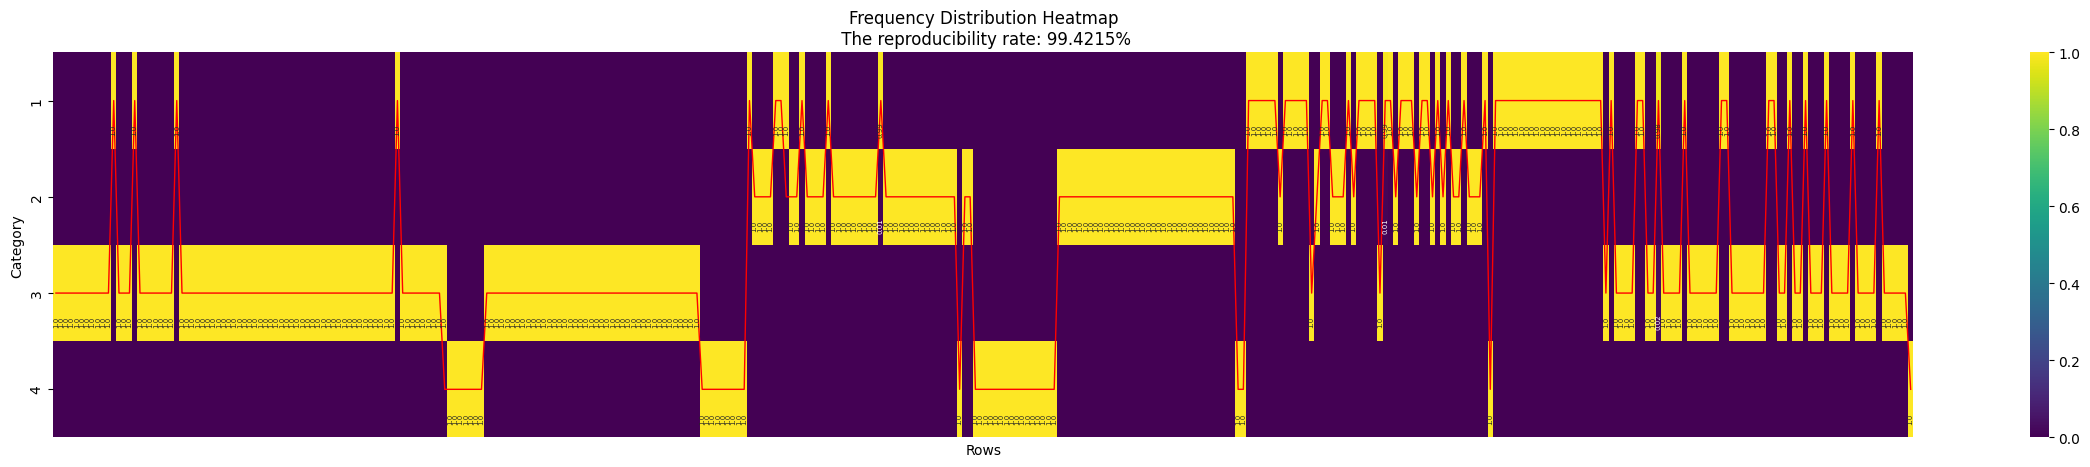


计算 ARI 统计量:
原始结果与复现结果之间的ARI 95%置信区间: (0.9781940658484397, 0.9867955409511189);随机误差范围: (0.9913211409622026, 1.0)
ARI置信区间覆盖率: 0.40；概率0.0003


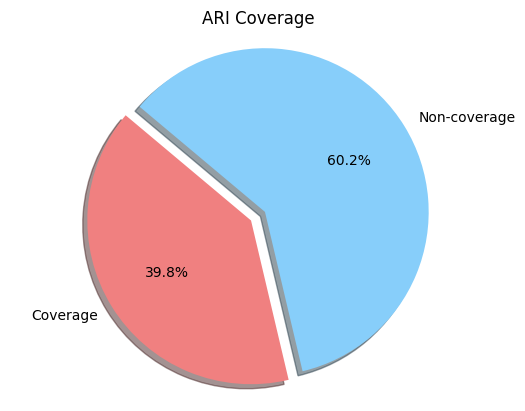


计算 NMI 统计量:
原始结果与复现结果之间的NMI 95%置信区间: (0.9634562260015589, 0.9761286714830318);随机误差范围: (0.9872989784109204, 1.0)
NMI置信区间覆盖率: 0.35；概率0.0005


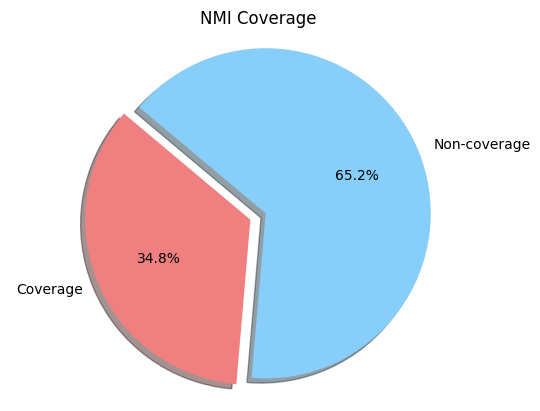


计算 Kappa 统计量:
原始结果与复现结果之间的Kappa 95%置信区间: (0.9876985092261181, 0.9918068831439351);随机误差范围: (0.9958941764576253, 1.0)
Kappa置信区间覆盖率: 0.33；概率0.0193


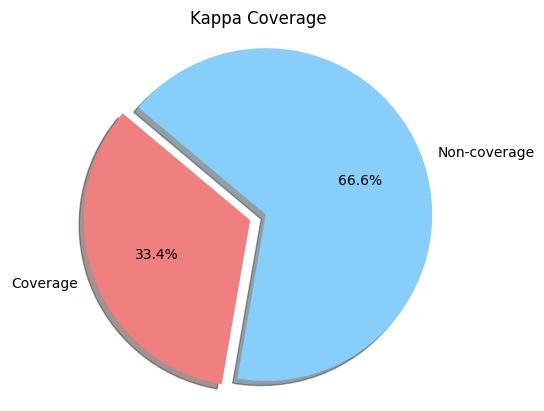